# Fitbit Exploration
For an explanation on the variables, take a look at the [data dictionary created by Fitabase](https://www.fitabase.com/media/1546/fitabasedatadictionary.pdf).

## Sleep Schedule Check
In this notebook we take a look at how participants' sleep schedules might have shifted due to the pandemic. We have to include participants from the first cohort only since these are the ones that would have had data from before the seriousness of the pandemic started to affect students i.e. Spring Break.

In [1]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Daily Data
We start by looking at the largest averaging window: daily recorded events.

In [2]:
daily_fitbit = pd.read_csv("../data/processed/bpeace2-fitbit-daily.csv",index_col=0,parse_dates=True)
daily_fitbit.head()

,activities_calories,activities_caloriesBMR,activities_steps,activities_distance,activities_minutesSedentary,activities_minutesLightlyActive,activities_minutesFairlyActive,activities_minutesVeryActive,activities_activityCalories,body_bmi,body_fat,body_weight,foods_log_caloriesIn,foods_log_water,beiwe
date,,,,,,,,,,,,,,,
2020-05-13,2781.0,1876.0,9207,4.396294,1241,70,118,11,1097.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-14,3727.0,1876.0,15207,7.261114,614,263,134,23,2234.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-15,3909.0,1876.0,14556,8.028501,577,205,57,108,2381.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-16,3927.0,1876.0,18453,8.748670,760,176,24,151,2364.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-17,4180.0,1876.0,15425,7.973149,605,207,50,131,2652.0,23.754,0.0,180.0,0.0,0.0,hfttkth7


Adding a column for total active minutes which should give us a picture of whether or not their device was on the entire day.

In [3]:
daily_fitbit["activities_minutes"] = daily_fitbit[["activities_minutesSedentary","activities_minutesLightlyActive",
                                                "activities_minutesFairlyActive","activities_minutesVeryActive"]].sum(axis=1)
daily_fitbit["activities_percentage"] = daily_fitbit["activities_minutes"] / 1440 * 100
# checking to see if it makes sense - should be 1440
print("Max number of activity minutes:",np.max(daily_fitbit["activities_minutes"]))
# finding cutoffs for other variables
print("Max number of steps taken (for visualizing purposes):",np.max(daily_fitbit["activities_steps"]))
print("Max number of calories burned (for visualizing purposes):",np.max(daily_fitbit["activities_calories"]))

Max number of activity minutes: 1440
Max number of steps taken (for visualizing purposes): 37485
Max number of calories burned (for visualizing purposes): 6089.0


## Data Availability

### Heatmaps
Looking at heatmaps per participant to see logged data

Working for activities_calories
	Data collected
	Plotting


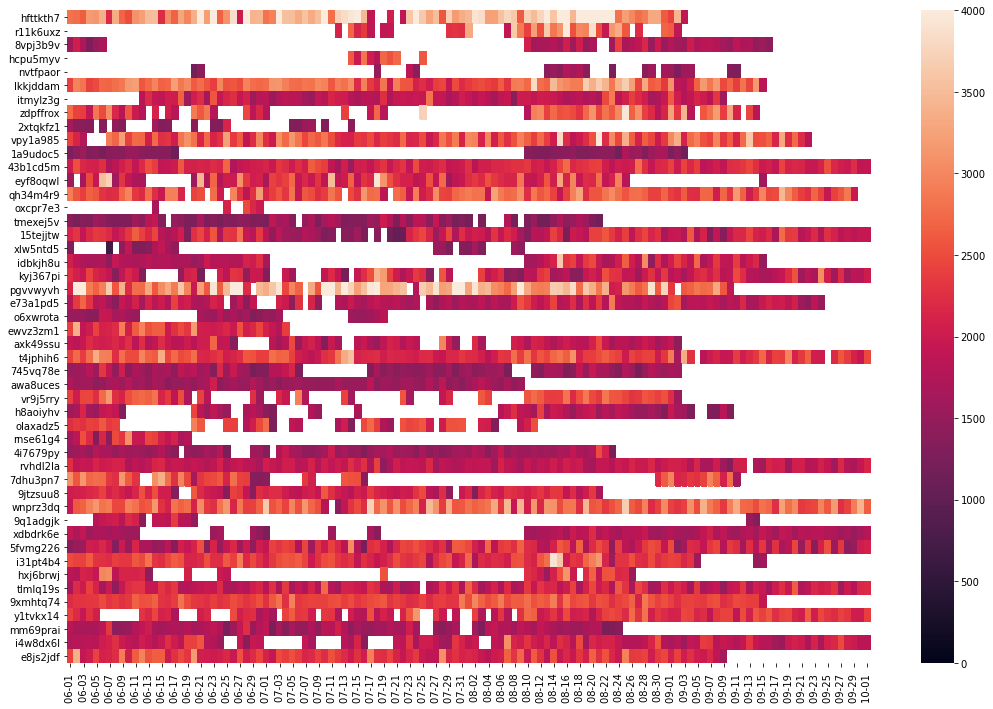

Working for activities_steps
	Data collected
	Plotting


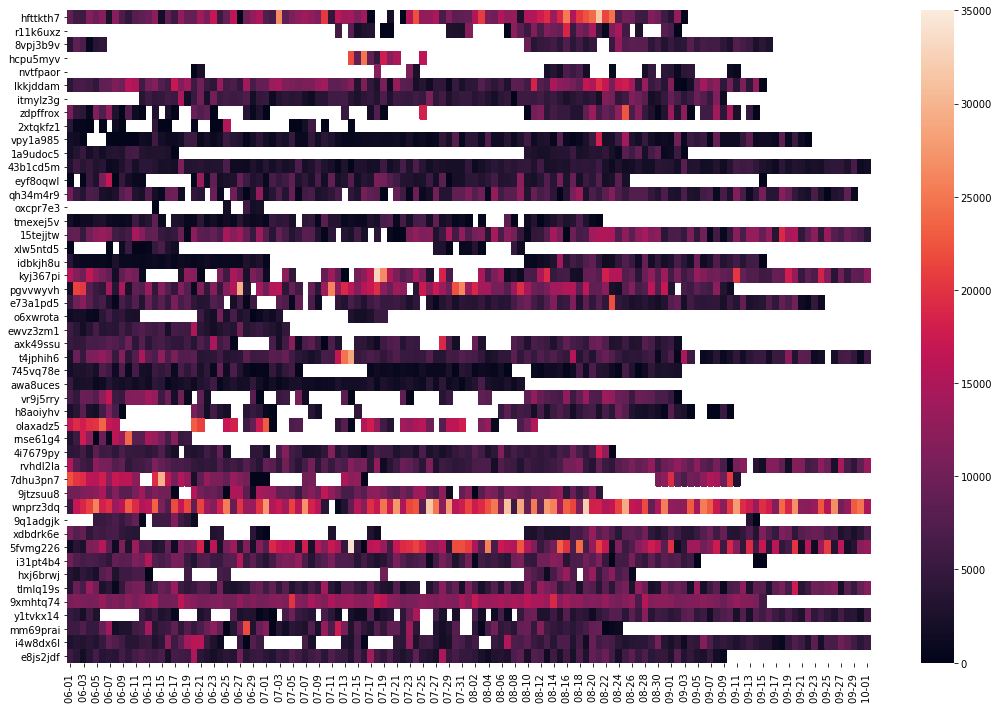

Working for activities_minutes
	Data collected
	Plotting


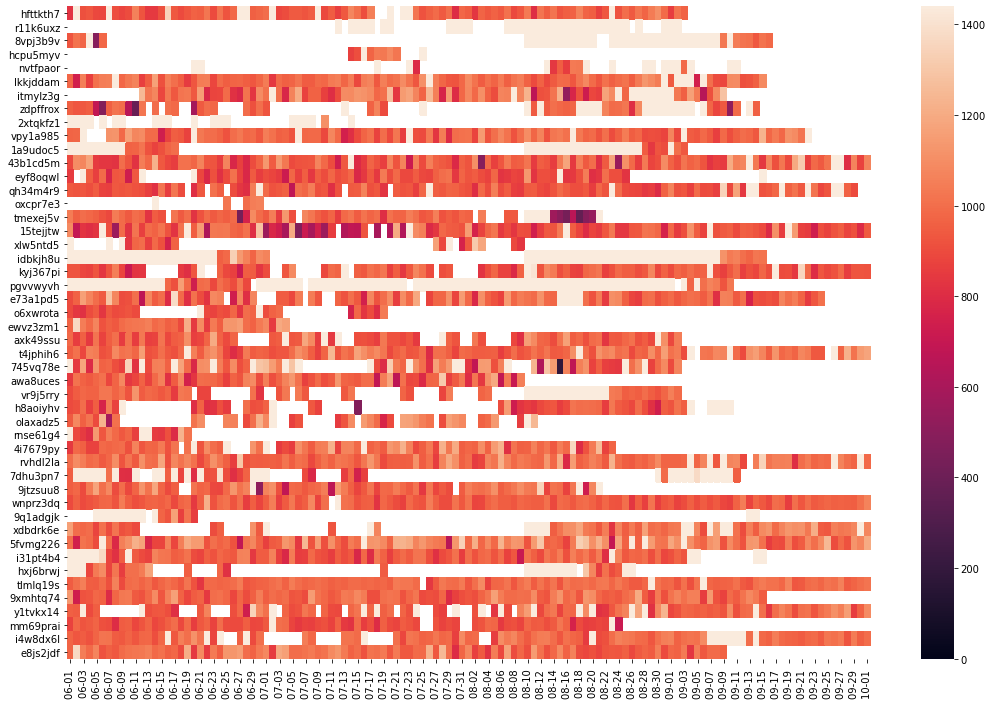

Working for activities_percentage
	Data collected
	Plotting


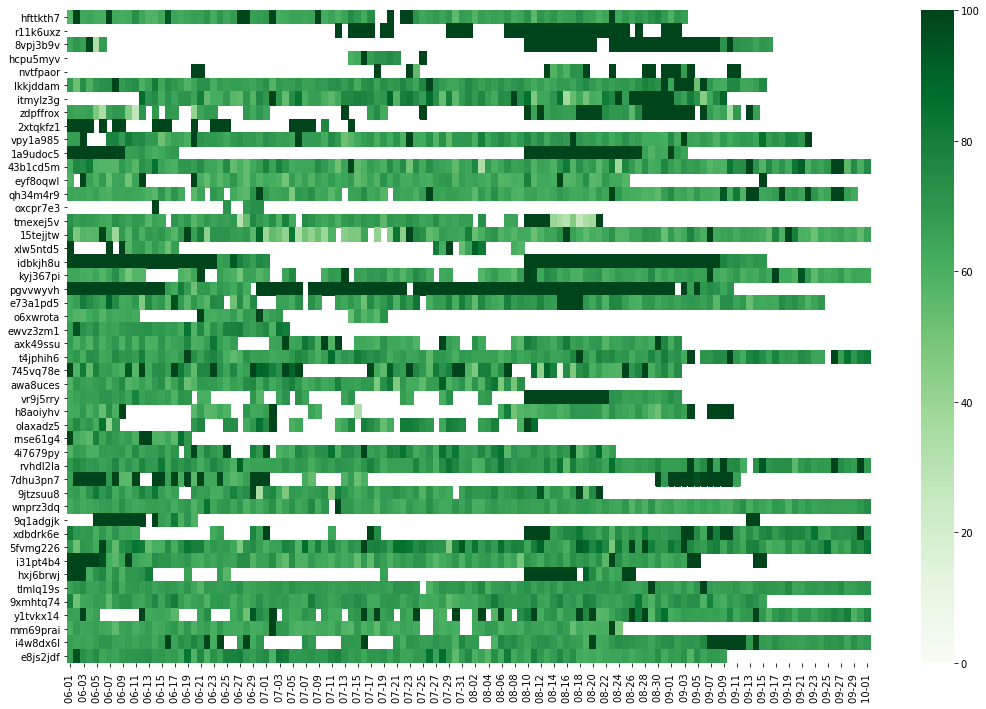

In [4]:
var_list = ['activities_calories','activities_steps','activities_minutes','activities_percentage']
limit_list = [[0,4000],[0,35000],[0,1440],[0,100]]
fb_completeness = pd.DataFrame()
for variable, limits in zip(var_list, limit_list):
    print(f'Working for {variable}')
    heatmap_df = pd.DataFrame()
    for beiwe in daily_fitbit['beiwe'].unique():
        daily_fitbit_by_beacon = daily_fitbit[daily_fitbit['beiwe'] == beiwe]
        sdate = datetime(2020,6,1)
        edate = datetime(2020,10,1)
        daily_fitbit_by_beacon = daily_fitbit_by_beacon[sdate:edate]
        heatmap_df = pd.concat([heatmap_df,daily_fitbit_by_beacon[variable]],axis=1)
        heatmap_df.rename(columns={variable:beiwe}, inplace=True)

    print(f'\tData collected')
    fig, ax = plt.subplots(figsize=(18,12))
    df_to_plot = heatmap_df.T
    print(f'\tPlotting')
    if variable == 'activities_percentage':
        sns.heatmap(df_to_plot,vmin=limits[0],vmax=limits[1],cmap='Greens',ax=ax)
        fb_completeness = df_to_plot
    else:
        sns.heatmap(df_to_plot,vmin=limits[0],vmax=limits[1],ax=ax)
    xlabels = ax.get_xticklabels()
    new_xlabels = []
    for label in xlabels:
        new_xlabels.append(label.get_text()[5:11])
        
    ax.set_xticklabels(new_xlabels)
    
    plt.savefig(f'../reports/utx000_initial_update/figures/time-fitbit-{variable}-heatmap.pdf')
    plt.show()
    plt.close()

<div class="alert alert-block alert-warning">

The last figure gives the best insight into the available data from each participant. Cells with the lightest color correspond to 1440 minutes (1 day) meaning the Fitbit recorded data all day. 
    
</div>

<div class="alert alert-block alert-success">
We can improve upon the last figure, but converting the sum of minutes to a percentage and then plotting a heatmap of that!

More analysis on the completeness of Fitbit data is warranted. Here we look at the overall completeness of the participants' data collection and the number of days above a certain percentage of data collection.

### Number of Participants

In [5]:
n_pts = len(daily_fitbit['beiwe'].unique())
print(f'Number of Overall Participants: {n_pts}')
pts_daily = np.sort(daily_fitbit['beiwe'].unique())

Number of Overall Participants: 48


Checking participants for each metric in ```daily_fitbit```

In [6]:
for col in daily_fitbit.columns:
    if col != 'beiwe':
        print(f'{col}:')
        temp_fitbit = daily_fitbit[[col,'beiwe']].dropna()
        n = len(temp_fitbit['beiwe'].unique())
        print(f'\tNumber of participants: {n}')

activities_calories:
	Number of participants: 48
activities_caloriesBMR:
	Number of participants: 48
activities_steps:
	Number of participants: 48
activities_distance:
	Number of participants: 48
activities_minutesSedentary:
	Number of participants: 48
activities_minutesLightlyActive:
	Number of participants: 48
activities_minutesFairlyActive:
	Number of participants: 48
activities_minutesVeryActive:
	Number of participants: 48
activities_activityCalories:
	Number of participants: 48
body_bmi:
	Number of participants: 48
body_fat:
	Number of participants: 48
body_weight:
	Number of participants: 48
foods_log_caloriesIn:
	Number of participants: 48
foods_log_water:
	Number of participants: 48
activities_minutes:
	Number of participants: 48
activities_percentage:
	Number of participants: 48


### Number of Hours
We can use the activity minutes to get a sense of the number of minutes that were collected by the fitbit.

In [7]:
n_hours = np.sum(daily_fitbit['activities_minutes'] / 60)
print(f'Number of hours of data collected: {n_hours}')
print(f'Number of days of data collected: {n_hours / 24}')

Number of hours of data collected: 77719.81666666667
Number of days of data collected: 3238.3256944444443


### Average completeness when wearing the Fitbit

In [8]:
fb_completeness['Average'] = fb_completeness.mean(axis=1)

With the new column, now we can plot and see What the average completion is.

NameError: name 'bid' is not defined

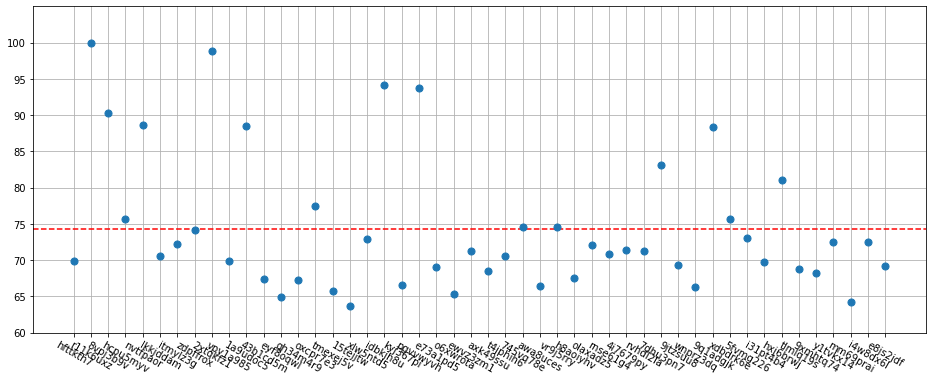

In [9]:
fig, ax = plt.subplots(figsize=(16,6))
# scattering number of nights recorded eper participant
ax.scatter(fb_completeness.index,fb_completeness['Average'],s=50,zorder=10)
ax.set_yticks(np.arange(0,105,5))
ax.set_ylim([60,105])
plt.xticks(rotation=-30)
ax.grid(zorder=1)
# adding average line
ax.axhline(np.nanmean(fb_completeness['Average']),color='red',linestyle='dashed')
avg = int(np.nanmean(fb_completeness['Average']))
ax.text(bid[0],np.nanmean(fb_completeness['Average']),f'avg: {avg}',va='bottom',ha='center',color='red')
# adding max line
ax.axhline(np.nanmax(fb_completeness['Average']),color='red',linestyle='dashed')
m = int(np.nanmax(fb_completeness['Average']))
ax.text(bid[0],np.nanmax(fb_completeness['Average']),f'max: {m}',va='bottom',ha='center',color='red')
# adding min line
ax.axhline(np.nanmin(fb_completeness['Average']),color='red',linestyle='dashed')
m = int(np.nanmin(fb_completeness['Average']))
ax.text(bid[0],np.nanmin(fb_completeness['Average']),f'min: {m}',va='bottom',ha='center',color='red')

plt.savefig('../reports/utx000_initial_update/figures/beiwe-fitbit-daily-completeness.pdf')
plt.show()
plt.close()

Now we need to create new columns that have the specified cutoff values

In [10]:
temp_dict = {}
for cutoff in [0,50,75,85,95]:
    temp = fb_completeness[fb_completeness >= cutoff]
    temp_dict[cutoff] = temp.count(axis=1).values
    
cutoffs = pd.DataFrame(temp_dict)

And with that, now we plot with number of days and percetnage

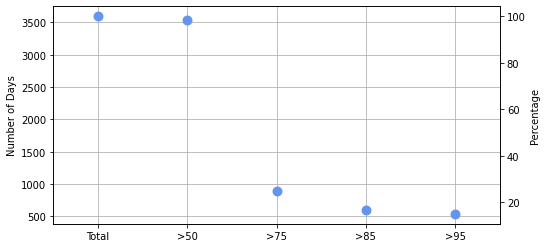

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
for i in range(len(cutoffs.columns)):
    ax.scatter(i,cutoffs.sum().iloc[i],color='cornflowerblue',zorder=4,s=80)
    #ax.text(i,cutoffs.sum().iloc[i],f'{cutoffs.sum().iloc[i]}',ha='left',va='top',zorder=10)
    
ax.set_xlim([-0.5,4.5])
ax.set_xticks(np.arange(0,5,1))
ax.set_xticklabels(['Total','>50','>75','>85','>95'])
ax.set_ylabel('Number of Days')

ax2 = ax.twinx()
for i in range(len(cutoffs.columns)):
    ax2.scatter(i,cutoffs.sum().iloc[i]/cutoffs.sum().iloc[0]*100,color='cornflowerblue',zorder=2,alpha=0,s=125)
    
ax2.set_ylabel('Percentage')
ax.grid('both',zorder=1)

plt.savefig(f'../reports/utx000_initial_update/figures/fitbit-fitbit-daily-completeness-combined.pdf')
plt.savefig(f'../reports/BuildSys2020/fitbit-fitbit-daily-completeness-combined.pdf')
plt.show()
plt.close()

## Sleep Data
Sleep data is a subset of the daily data and we can check to see how many nights of data we have available at least from the current dataset.


In [12]:
daily_sleep = pd.read_csv("../data/processed/bpeace2-fitbit-sleep-daily.csv",index_col=0,parse_dates=True)
# converting duration to something that makes more sense...
daily_sleep['durationHours'] = daily_sleep['duration'] / 3600000
daily_sleep.head()

,dateOfSleep,duration,efficiency,endTime,infoCode,isMainSleep,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,minutesToFallAsleep,startTime,timeInBed,beiwe,durationHours
date,,,,,,,,,,,,,,,
2020-05-14,2020-05-14,24360000,97,2020-05-14T07:13:00.000,0,True,27170628887,0,379,27,0,2020-05-14T00:27:00.000,406,hfttkth7,6.766667
2020-05-15,2020-05-15,29580000,87,2020-05-15T08:06:30.000,0,True,27187368950,8,392,101,0,2020-05-14T23:53:30.000,493,hfttkth7,8.216667
2020-05-16,2020-05-16,19740000,95,2020-05-16T04:57:00.000,0,True,27197675883,7,287,42,0,2020-05-15T23:28:00.000,329,hfttkth7,5.483333
2020-05-17,2020-05-17,26820000,96,2020-05-17T09:28:30.000,0,True,27214680283,8,403,44,0,2020-05-17T02:01:30.000,447,hfttkth7,7.450000
2020-05-18,2020-05-18,24960000,92,2020-05-18T07:20:00.000,0,True,27227113904,0,351,65,0,2020-05-18T00:24:00.000,416,hfttkth7,6.933333


The [data dictionary](https://www.fitabase.com/media/1546/fitabasedatadictionary.pdf) for these variables can be quite enlightening as many of these variables are useless.

### Scatter of Number of Nights
Here we look at how many nights of data each participant recorded

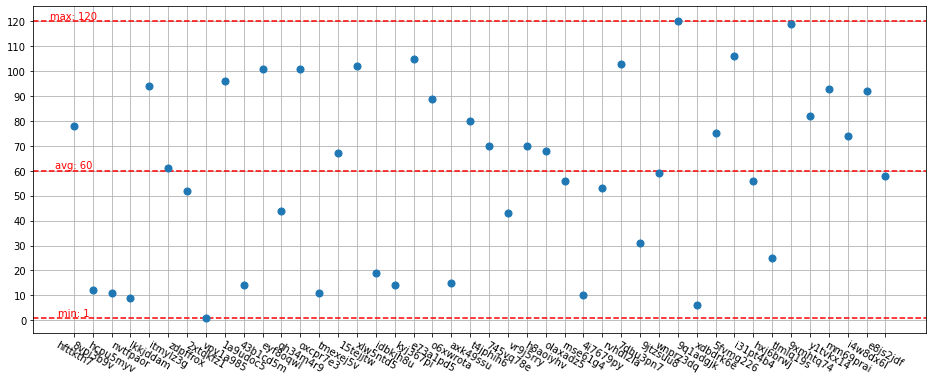

In [13]:
# Number of nights recorded
bid = []
sleep_recorded = []
# Looping through beiwe participants
for beiwe in daily_sleep['beiwe'].unique():
    sleep_by_beiwe = daily_sleep[daily_sleep['beiwe'] == beiwe]
    sleep_by_beiwe = sleep_by_beiwe[datetime(2020,6,1):datetime(2020,10,1)]
    bid.append(beiwe)
    sleep_recorded.append(len(sleep_by_beiwe))

fig, ax = plt.subplots(figsize=(16,6))
# scattering number of nights recorded eper participant
ax.scatter(bid,sleep_recorded,s=50,zorder=10)
ax.set_yticks(np.arange(0,130,10))
plt.xticks(rotation=-30)
ax.grid(zorder=1)
# adding average line
ax.axhline(np.nanmean(sleep_recorded),color='red',linestyle='dashed')
avg = int(np.nanmean(sleep_recorded))
ax.text(bid[0],np.nanmean(sleep_recorded),f'avg: {avg}',va='bottom',ha='center',color='red')
# adding max line
ax.axhline(np.nanmax(sleep_recorded),color='red',linestyle='dashed')
ax.text(bid[0],np.nanmax(sleep_recorded),f'max: {np.nanmax(sleep_recorded)}',va='bottom',ha='center',color='red')
# adding min line
ax.axhline(np.nanmin(sleep_recorded),color='red',linestyle='dashed')
ax.text(bid[0],np.nanmin(sleep_recorded),f'min: {np.nanmin(sleep_recorded)}',va='bottom',ha='center',color='red')

plt.savefig('../reports/utx000_initial_update/figures/beiwe-fitbit-number-nights-recorded.pdf')
plt.show()
plt.close()

In [14]:
days = (datetime(2020,10,1) - datetime(2020,6,1)).days
print(f'Maximum number of days: {days}')
print(f'Number of total nights recorded: {np.sum(sleep_recorded)}')

Maximum number of days: 122
Number of total nights recorded: 2645


### Histograms
Now we take a look at the typical values recorded for various components of sleep.

#### Typical Sleep Quantification Values
Here we look at TST and Efficiency distributions.

Working for durationHours
	Plotting


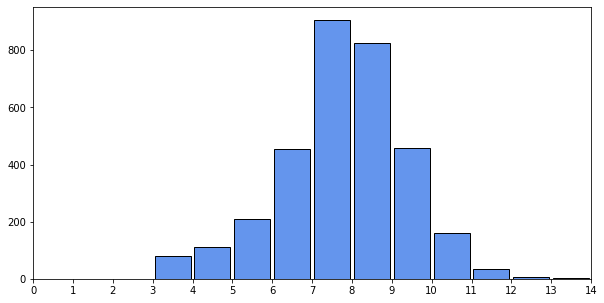

Working for efficiency
	Plotting


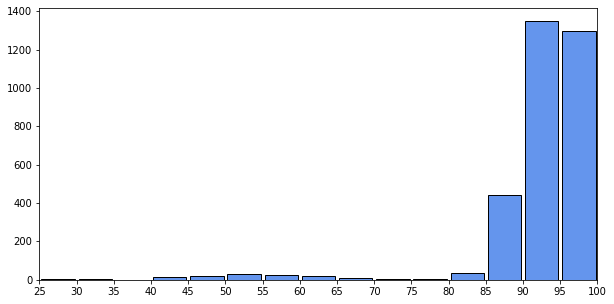

In [15]:
var_list = ['durationHours','efficiency']
bins=[np.arange(0,15,1),
     np.arange(25,105,5)]
for variable,bin_amt in zip(var_list,bins):
    print(f'Working for {variable}')
    fig, ax = plt.subplots(figsize=(10,5))
    print(f'\tPlotting')
        
    ax.hist(daily_sleep[variable],color="cornflowerblue",edgecolor="black",rwidth=0.9,bins=bin_amt)
    ax.set_xticks(bin_amt)
    ax.set_xlim([bin_amt[0],bin_amt[-1]])
    
    plt.show()
    plt.close()

#### Minute Recordings
These histograms summarize some of the (what look like) important data that are on similar minute-scales.

Working for minutes summary
	Plotting
Working for minutes summary
	Plotting
Working for minutes summary
	Plotting


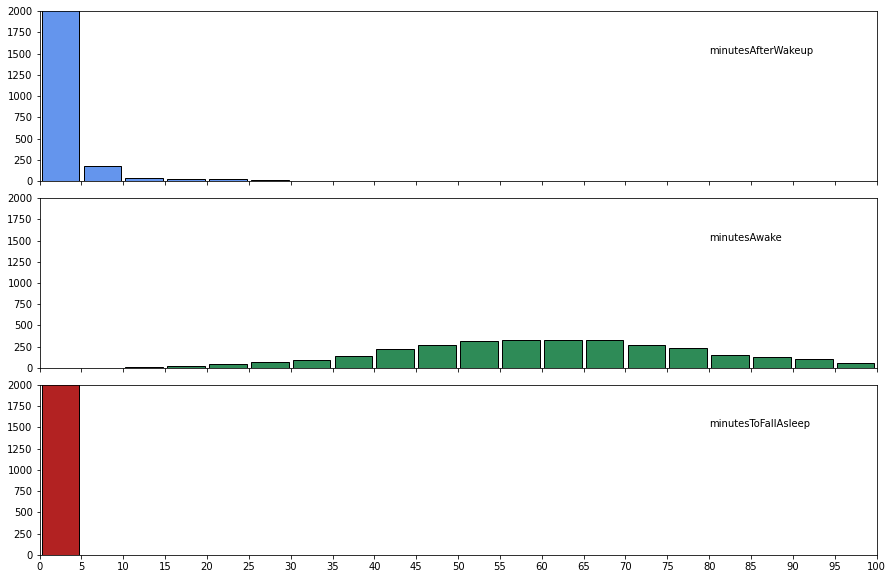

In [16]:
var_list = ['minutesAfterWakeup','minutesAwake','minutesToFallAsleep']
colors= ["cornflowerblue","seagreen","firebrick"]
fig, axes = plt.subplots(3,1,figsize=(15,10),sharex=True)
bins = np.arange(0,105,5)
for i in range(len(var_list)):
    print(f'Working for minutes summary')
    print(f'\tPlotting')
        
    axes[i].hist(daily_sleep[var_list[i]],color=colors[i],edgecolor="black",rwidth=0.9,bins=bins)
    axes[i].set_xticks(bins)
    axes[i].set_xlim([bins[0],bins[-1]])
    axes[i].set_ylim([0,2000])
    
    axes[i].text(80,1500,var_list[i])
    
plt.subplots_adjust(hspace=0.1)
plt.show()
plt.close()

<div class="alert alert-block alert-info">
These variables provide us with some potential links to explore:
    <ul>
        <li>TST and IAQ</li>
        <li>Efficiency and IAQ</li>
        <li>Minutes Awake and IAQ</li>
        <li>Awake Count and IAQ</li>
        <li>Awakenings Count and IAQ</li>
        <li>Restless Count and IAQ (might be similar to previous point)</li>  
    </ul>
</div>

### Heatmaps
Heatmaps will show gaps and give us a decent idea of the values measured.

In [17]:
# Getting extreme values
print(np.min(daily_sleep['durationHours']))
print(np.max(daily_sleep['durationHours']))
print(np.min(daily_sleep['efficiency']))
print(np.max(daily_sleep['efficiency']))

3.0166666666666666
17.683333333333334
27
100


Working for durationHours
	Data collected
	Plotting


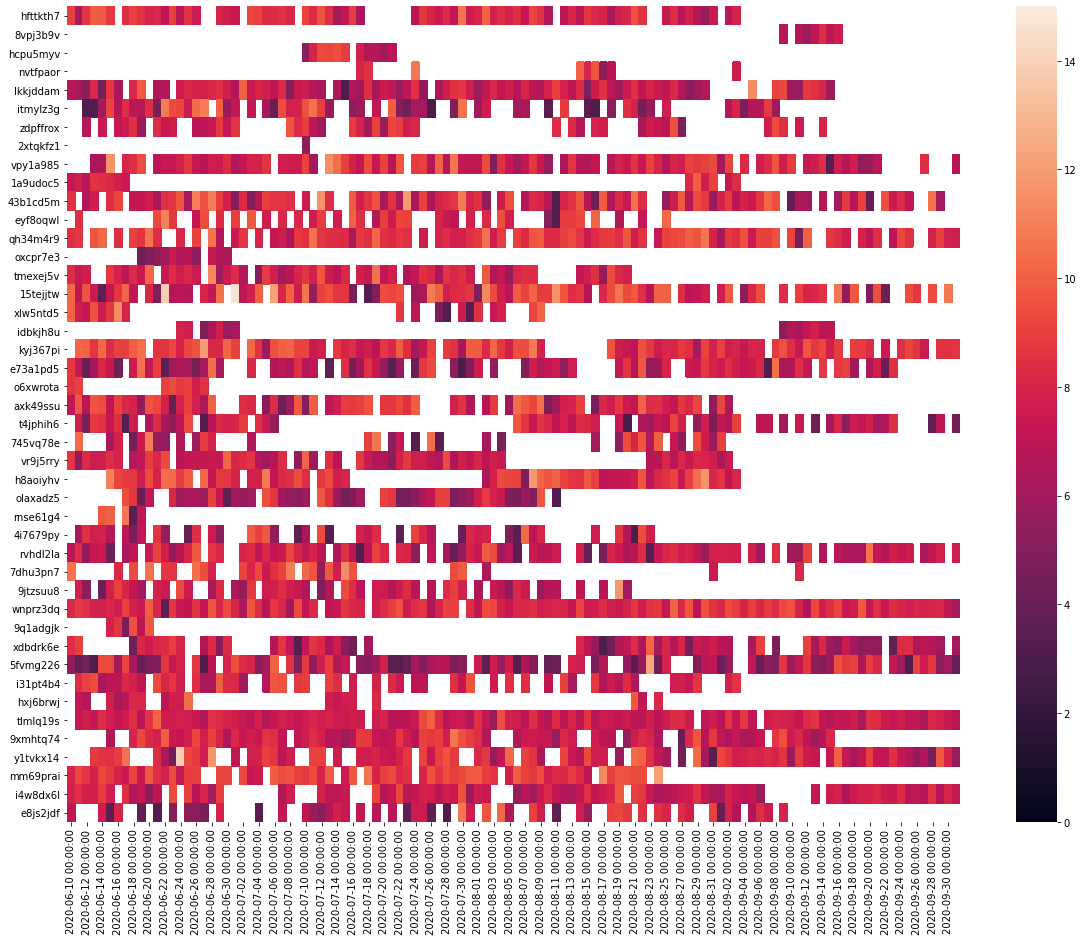

Working for efficiency
	Data collected
	Plotting


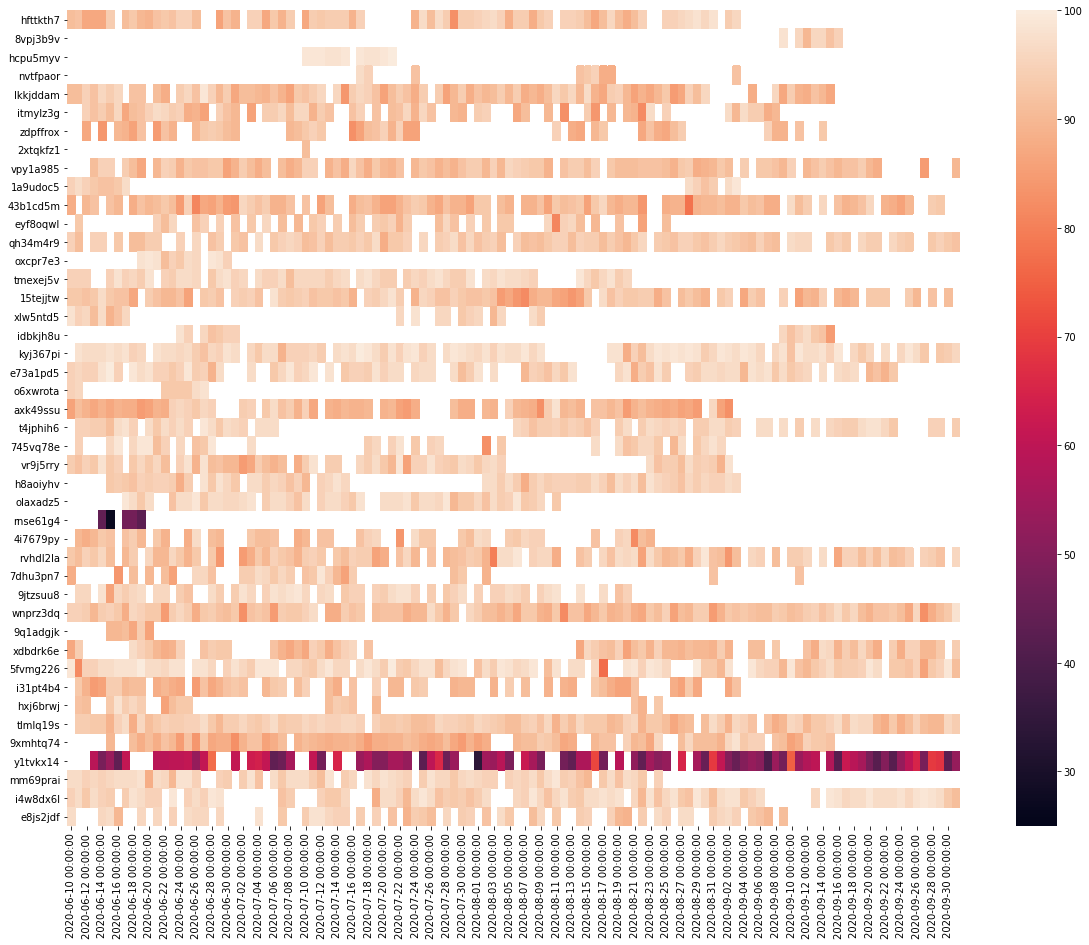

In [18]:
var_list = ['durationHours','efficiency',]
limit_list = [[0,15],[25,100]]
for variable, limits in zip(var_list, limit_list):
    print(f'Working for {variable}')
    heatmap_df = pd.DataFrame()
    for beiwe in daily_sleep['beiwe'].unique():
        daily_fitbit_by_beacon = daily_sleep[daily_sleep['beiwe'] == beiwe]
        sdate = datetime(2020,6,10)
        edate = datetime(2020,10,20)
        daily_fitbit_by_beacon = daily_fitbit_by_beacon[sdate:edate]
        heatmap_df = pd.concat([heatmap_df,daily_fitbit_by_beacon[variable]],axis=1)
        heatmap_df.rename(columns={variable:beiwe}, inplace=True)

    print(f'\tData collected')
    fig, ax = plt.subplots(figsize=(20,15))
    df_to_plot = heatmap_df.T
    print(f'\tPlotting')
    sns.heatmap(df_to_plot,vmin=limits[0],vmax=limits[1])
        
    #x_labels = []
    #for d in pd.date_range(sdate,edate-timedelta(days=1),freq='d'):
    #    x_labels.append(d.strftime('%m-%d'))
        
    #ax.set_xticklabels(x_labels)
    
    plt.show()
    plt.close()

## Sleep Minute Data
In addition to nightly summaries, we also have the minute data corresponding to the sleep stages recorded by Fitbit.

In [19]:
sleep_stages = pd.read_csv("../data/processed/bpeace2-fitbit-sleep-stages.csv",index_col=0,parse_dates=[1,2,3])

### Number of Participants
Trying to see if there is a disconnect between the daily and the intra-day stats.

In [20]:
n_pts_ss = len(sleep_stages['beiwe'].unique())
print(f'Number of Participants: {n_pts_ss}')
pts_ss = sleep_stages['beiwe'].unique()

Number of Participants: 44


There **is** a disconnect. Let's look at these participants:

In [21]:
np.sort(pts_daily)

array(['15tejjtw', '1a9udoc5', '2xtqkfz1', '43b1cd5m', '4i7679py',
       '5fvmg226', '745vq78e', '7dhu3pn7', '8vpj3b9v', '9jtzsuu8',
       '9q1adgjk', '9xmhtq74', 'awa8uces', 'axk49ssu', 'e73a1pd5',
       'e8js2jdf', 'ewvz3zm1', 'eyf8oqwl', 'h8aoiyhv', 'hcpu5myv',
       'hfttkth7', 'hxj6brwj', 'i31pt4b4', 'i4w8dx6l', 'idbkjh8u',
       'itmylz3g', 'kyj367pi', 'lkkjddam', 'mm69prai', 'nvtfpaor',
       'o6xwrota', 'olaxadz5', 'oxcpr7e3', 'pgvvwyvh', 'qh34m4r9',
       'r11k6uxz', 'rnse61g4', 'rvhdl2la', 't4jphih6', 'tlmlq19s',
       'tmexej5v', 'vpy1a985', 'vr9j5rry', 'wnprz3dq', 'xdbdrk6e',
       'xlw5ntd5', 'y1tvkx14', 'zdpffrox'], dtype=object)

In [22]:
np.sort(pts_ss)

array(['15tejjtw', '1a9udoc5', '2xtqkfz1', '43b1cd5m', '4i7679py',
       '5fvmg226', '745vq78e', '7dhu3pn7', '8vpj3b9v', '9jtzsuu8',
       '9q1adgjk', '9xmhtq74', 'axk49ssu', 'e73a1pd5', 'e8js2jdf',
       'eyf8oqwl', 'h8aoiyhv', 'hcpu5myv', 'hfttkth7', 'hxj6brwj',
       'i31pt4b4', 'i4w8dx6l', 'idbkjh8u', 'itmylz3g', 'kyj367pi',
       'lkkjddam', 'mm69prai', 'nvtfpaor', 'o6xwrota', 'olaxadz5',
       'oxcpr7e3', 'qh34m4r9', 'rnse61g4', 'rvhdl2la', 't4jphih6',
       'tlmlq19s', 'tmexej5v', 'vpy1a985', 'vr9j5rry', 'wnprz3dq',
       'xdbdrk6e', 'xlw5ntd5', 'y1tvkx14', 'zdpffrox'], dtype=object)

### Histogram of Values
We can look at the values to see the relative abundance of each type of sleep parameter.

### Sleep Times
Unfortunately the data from the minute sleep dataframe is rather useless since it does not supply us with anything more important than the daily summary other than the start and stop times of sleep. Below is a simple figure that shows the periods when participants went to sleep and woke up. 

## Heart Rate
Now we look at the heart rate data

In [23]:
fitbit_intra = pd.read_csv('../data/processed/bpeace2-fitbit-intraday.csv',
            index_col=0, parse_dates=True, infer_datetime_format=True)
fitbit_intra[:10]

,activities_calories,activities_steps,activities_distance,activities_heart,beiwe
date,,,,,
2020-05-13 17:39:00,1.69377,NaN,NaN,77.333333,hfttkth7
2020-05-13 17:40:00,1.69377,NaN,NaN,77.600000,hfttkth7
2020-05-13 17:41:00,4.42986,33.0,0.015721,79.000000,hfttkth7
2020-05-13 17:42:00,1.69377,NaN,NaN,83.416667,hfttkth7
2020-05-13 17:43:00,1.43319,NaN,NaN,63.666667,hfttkth7
2020-05-13 17:44:00,NaN,NaN,NaN,64.222222,hfttkth7
2020-05-13 17:45:00,NaN,NaN,NaN,64.142857,hfttkth7
2020-05-13 17:46:00,1.43319,NaN,NaN,64.428571,hfttkth7
2020-05-13 17:47:00,NaN,NaN,NaN,63.800000,hfttkth7


### Number of Participants

In [24]:
n_pts = len(fitbit_intra['beiwe'].unique())
print(f'Number of participants: {n_pts}')
pts_hourly = np.sort(fitbit_intra['beiwe'].unique())

Number of participants: 48


In [25]:
daily_but_no_hourly = daily_fitbit[daily_fitbit['beiwe'] == '5fvmg226']
daily_but_no_hourly

,activities_calories,activities_caloriesBMR,activities_steps,activities_distance,activities_minutesSedentary,activities_minutesLightlyActive,activities_minutesFairlyActive,activities_minutesVeryActive,activities_activityCalories,body_bmi,body_fat,body_weight,foods_log_caloriesIn,foods_log_water,beiwe,activities_minutes,activities_percentage
date,,,,,,,,,,,,,,,,,
2020-05-01,2058.0,1207.0,11499,4.774256,557,399,0,0,1143.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,956,66.388889
2020-05-02,1680.0,1207.0,4683,1.953970,715,228,0,0,609.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,943,65.486111
2020-05-03,2010.0,1207.0,8802,3.645591,492,368,17,1,1081.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,878,60.972222
2020-05-04,1484.0,1207.0,1999,0.811237,821,153,0,0,362.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,974,67.638889
2020-05-05,2058.0,1207.0,11615,4.824947,461,408,0,0,1151.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,869,60.347222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,2328.0,1202.0,15810,6.592487,478,492,18,1,1495.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,989,68.680556
2020-09-28,1431.0,1202.0,1946,0.811958,798,119,0,0,294.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,917,63.680556
2020-09-29,1524.0,1202.0,3410,1.422990,969,144,10,0,409.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,1123,77.986111
